In [ ]:
# Download kaggle data in Google Colab
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'kuantinglai/taiwanese-food-101'
! mkdir taiwanese-food-101
! unzip taiwanese-food-101.zip -d taiwanese-food-101

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os
import csv
import numpy as np
from tensorflow.keras.models import load_model
import glob, tqdm
from PIL import Image

In [ ]:
root_dir = '/content/taiwanese-food-101/tw_food_101/tw_food_101'
train_dir = root_dir + '/train'
test_dir = root_dir + '/test'

In [ ]:
# data preprocess
train_datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255,)

valid_datagen = ImageDataGenerator(
        rescale=1./255,)

image_size = (180, 180)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode = "rgb",
    batch_size= 50,
    class_mode='categorical',
    shuffle = True)
valid_generator = valid_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode = "rgb",
    batch_size= 50,
    class_mode='categorical',
    shuffle = True)

Found 20372 images belonging to 101 classes.
Found 20372 images belonging to 101 classes.


In [ ]:
base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(*image_size, 3))

In [ ]:
# dense model
base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(*image_size, 3))
# LR function
LR_function=ReduceLROnPlateau(monitor='val_accuracy',
                              patience=3,
                              verbose=1,
                              factor=0.5,# lr*0.5
                              min_lr=0.000001
                             )
adam = Adam(learning_rate=0.0001)

estop = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=6)

scp = tensorflow.keras.callbacks.ModelCheckpoint(
    'model.h5',
    monitor = "val_accuracy",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "auto",
    save_freq ="epoch",
)

In [ ]:
# extra model
x = base_model.output
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(101, activation='softmax')(x)
model = Model(base_model.input, pred)
# comppile
model.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 186, 186, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 90, 90, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 90, 90, 64)           256       ['conv1/conv[0][0]']      

In [ ]:
# train
history = model.fit(
      train_generator,
      epochs=20,
      callbacks=[LR_function, estop, scp],
      validation_data=valid_generator,
      validation_steps=None,
      validation_batch_size=None,
      validation_freq=1,
      workers=10
)

Epoch 1/20
133/408 [========>.....................] - ETA: 3:57 - loss: 4.5257 - accuracy: 0.0581

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/408 [==========>...................] - ETA: 3:39 - loss: 4.4236 - accuracy: 0.0700

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


408/408 [==============================] - ETA: 0s - loss: 3.4397 - accuracy: 0.2250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 613s 1s/step - loss: 3.4397 - accuracy: 0.2250 - val_loss: 1.6327 - val_accuracy: 0.5796 - lr: 1.0000e-04
Epoch 2/20
408/408 [==============================] - 514s 1s/step - loss: 1.9586 - accuracy: 0.5054 - val_loss: 1.3435 - val_accuracy: 0.6379 - lr: 1.0000e-04
Epoch 3/20
408/408 [==============================] - 518s 1s/step - loss: 1.5452 - accuracy: 0.6064 - val_loss: 1.2216 - val_accuracy: 0.6778 - lr: 1.0000e-04
Epoch 4/20
408/408 [==============================] - 512s 1s/step - loss: 1.3043 - accuracy: 0.6571 - val_loss: 1.3955 - val_accuracy: 0.6390 - lr: 1.0000e-04
Epoch 5/20
408/408 [==============================] - 518s 1s/step - loss: 1.1615 - accuracy: 0.6978 - val_loss: 1.0061 - val_accuracy: 0.7294 - lr: 1.0000e-04
Epoch 6/20
408/408 [==============================] - 563s 1s/step - loss: 1.0604 - accuracy: 0.7219 - val_loss: 0.9543 - val_accuracy: 0.7420 - lr: 1.0000e-04
Epoch 7/20
408/408 [==============================]

In [ ]:
# plot acc
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

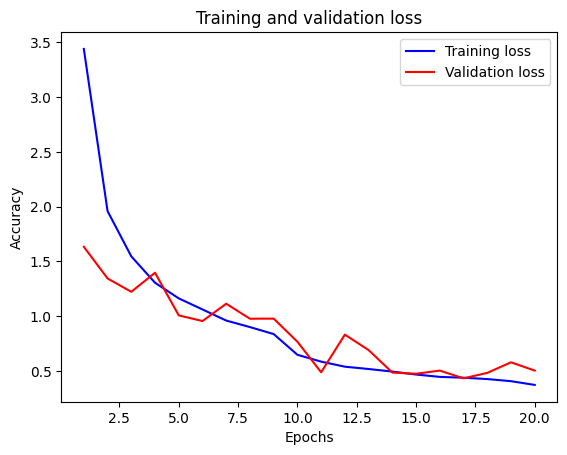

In [ ]:
# plot loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
